In [1]:
from sklearn.decomposition import PCA
#from ... import data_prep as dp
import matplotlib.pyplot as plt
import statistics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
import datetime as dt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.dates as mdates
import os
import mne


# 0. Define Colors

In [2]:
col_list = ["#377eb8", "#e41a1c"]

# 1.Functions for
## a) creating average amplitude for each independent session

In [24]:
def create_averages(sess_list, data_origin,prefix_calib,prefix_copy,file_extension):
    #creates an average of the independent sessions - outputs two files
    #     - Pickle file: create array sessions of shape(sess-1, 2(target/non_target), #of electrodes, #of timepoint))
    #     - csv: with time stamp for the samples
    #creates an average amplitude of each tactilo target and non-target 
    picks= ["Fz","Fc1","Fc2","C3","Cz","C4","Pz"]
    sess_averages = np.zeros((len(sess_list),2,len(picks),462)) # create array sessions, (sess-1,[target, nontarget],(["Fz","Fc1","Fc2","C3","Cz","C4","Pz"], (timepoints))
    num_tactilos = 4 if "4" in prefix_calib else 6
    mean_amplitudes = pd.DataFrame(columns=["Session","Electrode","Tactilo","Mean Amplitude","Condition"])
    for i,sess in enumerate(sess_list):
        data_paths = []
        data_paths.append(data_origin + prefix_calib + str(sess).zfill(3) + ".pickle")
        data_paths.append(data_origin + prefix_copy + str(sess).zfill(3) + ".pickle")

        mne.set_log_level('WARNING')
        for data_path in data_paths:
            if 'Calib' in data_path:
                raw_list =[]
            with open(data_path, "rb") as file:
                data_tuple = pickle.load(file)
                raw_list += data_tuple[0]
            if 'Calib' in data_path:
                continue
            
            for k, raw in enumerate(raw_list):
                raw_list[k] = raw.pick(picks).filter(l_freq=0.1, h_freq=40) # band-pass filter
                
            raw = mne.concatenate_raws(raw_list)
            events, event_id = mne.events_from_annotations(raw)
            event_id.pop('10')
            epochs= mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=0.8, preload=True,picks=picks,event_repeated='merge',baseline=(None,0),reject=dict(eeg=100e-6))  # timewindow -0.85 so its' 0.8 after resampling baseline=(-0.100,0)
            epochs = epochs.pick_channels(picks,ordered = True) # assure channels are in the same order as picks
            
            for tactilo in range(1,num_tactilos+1):
                target_tac = '1/10'+str(tactilo)
                df = pd.DataFrame((epochs[target_tac].average()._data*1e6).T)
                df.index = epochs.times
                for electrode,amp in enumerate(df[0.35: 0.6].mean().to_list()):
                    mean_amplitudes.loc[len(mean_amplitudes)] =[sess,picks[electrode],str(tactilo),amp,"Target"]
            for tactilo in range(1,num_tactilos+1):
                non_target_tac = '0/10'+str(tactilo)
                df = pd.DataFrame((epochs[non_target_tac].average()._data*1e6).T)
                df.index = epochs.times
                for electrode,amp in enumerate(df[0.35: 0.6].mean().to_list()):
                    mean_amplitudes.loc[len(mean_amplitudes)] =[sess,picks[electrode],str(tactilo),amp,"nonTarget"]
                
             
            nt_avg = epochs['0'].average()._data*1e6 #mne data in Volt! create evoked
            t_avg = epochs['1'].average()._data*1e6
            np.copyto(sess_averages[i,0,:,:],t_avg)
            np.copyto(sess_averages[i,1,:,:],nt_avg)
    print(r"created_data_LIS\average_amplitudes_350_600_"+file_extension+".csv")
    mean_amplitudes.to_csv(r"created_data_LIS\average_amplitudes_350_600_"+file_extension+".csv",index=False)
    np.savetxt(r"created_data_LIS\epoch_timetstamps_" + file_extension +".csv", epochs.times, delimiter=",")
    with open(r"created_data_LIS\average_amplitudes_" + file_extension +".pickle","wb") as file:
        pickle.dump(sess_averages, file)



## b)  amplitude plots

In [4]:
def plot_amplitude(amp_array,timestamps,electrodes_to_plot,title,y_lim):
    picks= ["Fz","Fc1","Fc2","C3","Cz","C4","Pz"]
    t= amp_array[:,0]
    t_avg = amp_array[:,0].mean(axis=0)
    nt =amp_array[:,1]
    nt_avg = amp_array[:,1].mean(axis=0)
    for e in electrodes_to_plot:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
        electrode = picks.index(e)
        ax.plot(timestamps, t_avg[electrode], label="Target", c=col_list[1])
        ax.plot(timestamps, nt_avg[electrode], label="Non-Target", c=col_list[0])
        t_std = np.std(t[:, electrode, :], axis=0)
        nt_std = np.std(nt[:, electrode, :], axis=0)
        t_ci = 1.96 * t_std / np.sqrt(t.shape[0])
        nt_ci = 1.96 * nt_std / np.sqrt(nt.shape[0])
        ax.fill_between(timestamps, t_avg[electrode] - t_ci, t_avg[electrode] + t_ci, alpha=0.3, color=col_list[1])
        ax.fill_between(timestamps, nt_avg[electrode] - nt_ci, nt_avg[electrode] + nt_ci, alpha=0.3,
                             color=col_list[0])
        ax.axvline(x=0, c='k', lw=0.5)
        ax.axhline(y=0, c='k', lw=0.5)
        ax.axvspan(0.35, 0.6, facecolor="#808080", alpha=0.3)
        ax.set_xlabel("seconds")
        ax.set_ylabel("µV")
        ax.margins(x=0)
        ax.set_title
        ax.set_ylim(y_lim)

        ax.legend(title="Average of Sessions with  "+title + " at " + e +" (n=" + str(t.shape[0]) + ")", loc='center', bbox_to_anchor=(0.5, 1.16), ncol=2)
        # fig.suptitle("Average over all sessions")
        fig.tight_layout()
        # plt.show()
        plt.savefig(r"created_data_LIS\average_"+e+"_Session_"+title+".svg", format="svg", transparent=True)


# 2. Create Averages of each session

In [26]:
#4 tactors
sess_list = range(1,31)
data_origin = r"G:\Meine Ablage\PhD\P300\LIS_Paper\Data\mne_raw_4tac"
prefix_calib = r"\4tac_Calib_S"
prefix_copy = r"\4tac_Copy_S"
file_extension = "4_tactors"

create_averages(sess_list, data_origin,prefix_calib,prefix_copy,file_extension)

#6 tactors - legs included
excluded_sessions = [4,7,10,11,12,16,18,19,20,32] #some sessions were training session which followed after the standard protocol (they happend on the same day and are excluded from analysis)
sess_list = [i for i in range(1,26) if i not in excluded_sessions]
data_origin = r"G:\Meine Ablage\PhD\P300\LIS_Paper\Data\mne_raw_6tac"
prefix_calib = r"\Calib_S"
prefix_copy = r"\Free_S"
file_extension = "6_tactors_legs_included"

create_averages(sess_list, data_origin,prefix_calib,prefix_copy,file_extension)

#6 tactors - legs excluded
excluded_sessions = [4,7,10,11,12,16,18,19,20,32] #some sessions were training session which followed after the standard protocol (they happend on the same day and are excluded from analysis)
sess_list = [i for i in range(26,50) if i not in excluded_sessions]
data_origin = r"G:\Meine Ablage\PhD\P300\LIS_Paper\Data\mne_raw_6tac"
prefix_calib = r"\Calib_S"
prefix_copy = r"\Free_S"
file_extension = "6_tactors_legs_excluded"

create_averages(sess_list, data_origin,prefix_calib,prefix_copy,file_extension)


     Session Electrode Tactilo  Mean Amplitude  Condition
0          1        Fz       1       -0.268341     Target
1          1       Fc1       1        1.585468     Target
2          1       Fc2       1        1.369481     Target
3          1        C3       1        2.134530     Target
4          1        Cz       1        2.606215     Target
...      ...       ...     ...             ...        ...
1675      30       Fc2       4        0.341097  nonTarget
1676      30        C3       4        0.459481  nonTarget
1677      30        Cz       4       -0.226749  nonTarget
1678      30        C4       4       -0.197657  nonTarget
1679      30        Pz       4       -0.420904  nonTarget

[1680 rows x 5 columns]
created_data_LIS\average_amplitudes_350_600_4_tactors.csv
     Session Electrode Tactilo  Mean Amplitude  Condition
0          1        Fz       1       -1.006197     Target
1          1       Fc1       1       -0.627132     Target
2          1       Fc2       1        0.633490 

# 3. Plot the averages

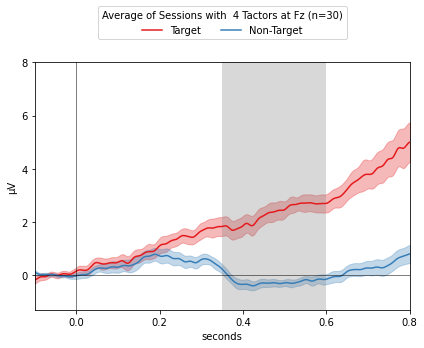

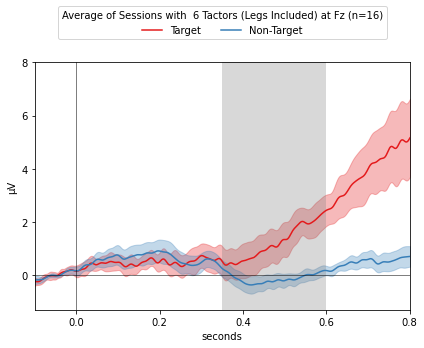

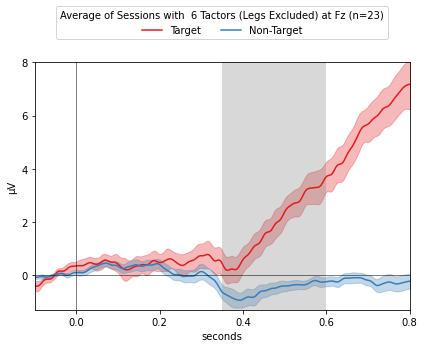

In [7]:
sections = ["4_tactors","6_tactors_legs_included","6_tactors_legs_excluded"]
titles = ["4 Tactors", r"6 Tactors (Legs Included)", r"6 Tactors (Legs Excluded)"]
for i,file_extension in enumerate(sections):
    with open(r"created_data_LIS\average_amplitudes_" + file_extension +".pickle","rb") as file:
           amp_array = pickle.load(file)
    timestamps = np.genfromtxt(r"created_data_LIS/epoch_timetstamps_" + file_extension +".csv", delimiter=',')
    electrodes_to_plot =["Fz","Cz","Pz"]
    y_lim = (-1.3,8)
    plot_amplitude(amp_array,timestamps,electrodes_to_plot,titles[i],y_lim)

# 4. Plot amplitudes over time (sessionwise)

In [27]:
tac4 = pd.read_csv(r"created_data_LIS\average_amplitudes_350_600_4_tactors.csv")
tac6_inlegs = pd.read_csv(r"created_data_LIS\average_amplitudes_350_600_6_tactors_legs_included.csv")
tac6_exlegs = pd.read_csv(r"created_data_LIS\average_amplitudes_350_600_6_tactors_legs_excluded.csv")
tac6_inlegs.Session = tac6_inlegs.Session +100 # add arbitray number to have unique session names
tac6_exlegs.Session = tac6_exlegs.Session +100
all_amp =pd.concat([tac4,tac6_inlegs,tac6_exlegs])

ascending_session_names = dict(zip(all_amp.Session.unique(),range(1,all_amp.Session.unique().size+1)))
all_amp.Session = all_amp["Session"].map(ascending_session_names)
all_amp.groupby(["Session","Condition"]).mean().to_csv(r"created_data_LIS\average_amplitudes_350_600_all.csv")

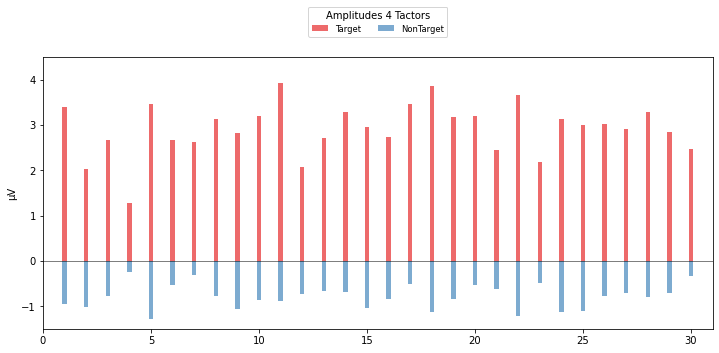

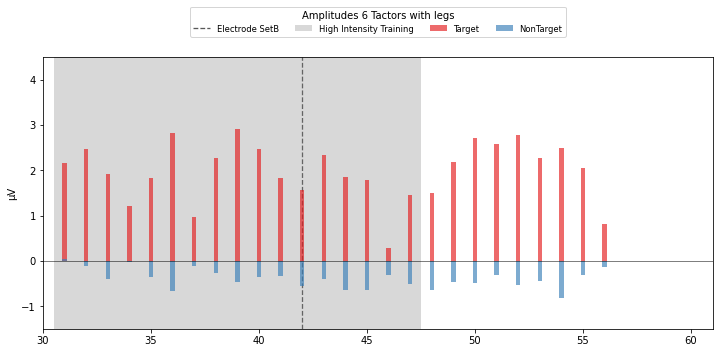

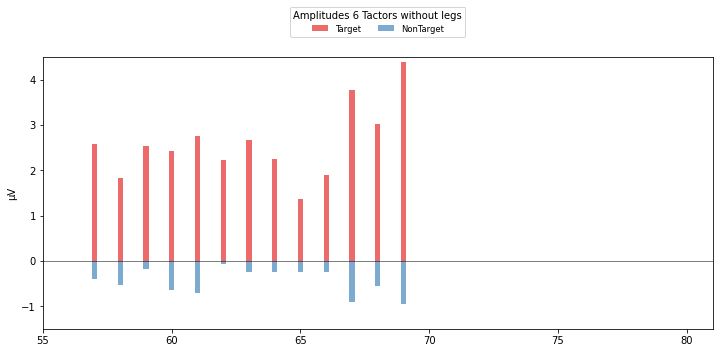

In [28]:
tac4 = all_amp.loc[all_amp.Session <31]
tac6_legs = all_amp.loc[(all_amp.Session >=31) &(all_amp.Session <57)]
tac6_no_legs = all_amp.loc[all_amp.Session >=57]
title= ["4 Tactors", "6 Tactors with legs", "6 Tactors without legs"]
x_lim=[(0,31),(30,61),(55,81)]

for i,data_set in enumerate([tac4,tac6_legs, tac6_no_legs]):
    tar_df = data_set.loc[(data_set.Condition == "Target") & (data_set.Electrode == "Cz")].groupby("Session").mean().reset_index(level=[0,0])
    ntar_df = data_set.loc[(data_set.Condition == "nonTarget")& (data_set.Electrode == "Cz")].groupby("Session").mean().reset_index(level=[0,0])

    fig, ax = plt.subplots(figsize = (12,5))
    if i==1:
        ax.axvline(x=42,alpha=0.65,zorder=0,c="k",ls="--",lw=1.3,label ="Electrode SetB" ) # electrode set b    
        ax.axvspan(30.5, 47.5, facecolor="#808080", alpha=0.3,label = "High Intensity Training")
    tar = ax.bar(tar_df["Session"],tar_df["Mean Amplitude"],color = col_list[1], width=0.2,alpha=0.65 ,label = "Target")
    ntar = ax.bar(ntar_df["Session"],ntar_df["Mean Amplitude"],color = col_list[0], width=0.2,alpha=0.65,label = "NonTarget")
    
    lgd =ax.legend(ncol=5, title="Amplitudes "+ title[i],loc='center', bbox_to_anchor=(0.5, 1.13),fontsize='small', fancybox=True)
    ax.axhline(y=0,c='k',lw=0.5)
    ax.set_ylabel("µV")
    ax.set_xlim(x_lim[i])
    ax.set_ylim((-1.5,4.5))

    fig.tight_layout
    plt.savefig(r"created_data_LIS\Timeline_" + title[i]+ ".svg",bbox_inches="tight",pad_inches=0.2,format="svg")    